In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [261]:
df = pd.read_csv('fraud_oracle.csv')

In [262]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [264]:
numerical_features = ['DriverRating'] 
categorical_features = [
        'Month', 'WeekOfMonth', 'DayOfWeek', 
        'Make', 'AccidentArea', 'DayOfWeekClaimed', 
        'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 
        'MaritalStatus', 'Fault', 'PolicyType', 
        'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 
        'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 
        'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 
        'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 
        'NumberOfCars', 'Year', 'BasePolicy', 'Deductible'
    ] 

target = 'FraudFound_P'  

features = numerical_features + categorical_features
X = df[features]
y = df[target]

In [265]:
def calculate_woe_iv_numeric(df, feature, target, bins=10):
    
    df = df[[feature, target]].copy()
    df['bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')

    grouped = df.groupby('bin', observed=True)[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped.columns = ['total', 'event', 'non_event']

    grouped['event_rate'] = grouped['event'] / grouped['event'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()

    eps = 0.0001 # to avoid division by zero
    grouped['woe'] = np.log((grouped['event_rate'] + eps) / (grouped['non_event_rate'] + eps))
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    iv = grouped['iv'].sum()
    
    return grouped, iv


In [266]:
def calculate_woe_iv_categorical(df, feature, target):
    
    df = df[[feature, target]].copy()

    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    grouped.columns = ['total', 'event', 'non_event']

    grouped['event_rate'] = grouped['event'] / grouped['event'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()

    eps = 0.0001 # to avoid division by zero
    grouped['woe'] = np.log((grouped['event_rate'] + eps) / (grouped['non_event_rate'] + eps))
    grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']

    iv = grouped['iv'].sum()
    
    return grouped, iv


In [267]:
def plot_woe(grouped, feature):
    plt.figure(figsize=(8, 4))
    plt.plot(grouped.index.astype(str), grouped['woe'], color='skyblue')
    plt.xlabel(f'Bins of {feature}')
    plt.ylabel('Weight of Evidence (WoE)')
    plt.title(f'WoE for {feature}')
    plt.xticks(rotation=45)
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.show()


In [268]:
iv_values = {}

In [269]:
for feature in numerical_features:
    _, iv = calculate_woe_iv_numeric(df, feature, target)
    iv_values[feature] = iv


In [270]:
for feature in categorical_features:
    _, iv = calculate_woe_iv_categorical(df, feature, target)
    iv_values[feature] = iv


In [271]:
sorted_iv_values = dict(sorted(iv_values.items(), key=lambda item: item[1]))
for feature, iv in sorted_iv_values.items():
    print(f"{feature}: {iv}")

MaritalStatus: 0.001193672158809876
WitnessPresent: 0.0014437386041200341
DriverRating: 0.00164834925488841
NumberOfCars: 0.002456178182701384
WeekOfMonth: 0.002828608792677209
Days_Policy_Claim: 0.003792937803013787
WeekOfMonthClaimed: 0.003965620458477362
PoliceReportFiled: 0.005580918525790644
DayOfWeekClaimed: 0.005778237483882976
Days_Policy_Accident: 0.008228492093973173
Year: 0.011086456505498643
DayOfWeek: 0.011656526677794547
AgentType: 0.01589667493404077
AccidentArea: 0.017369542252601913
Sex: 0.018008353271004085
NumberOfSuppliments: 0.02168129766134414
AgeOfVehicle: 0.023380263462269697
AgeOfPolicyHolder: 0.029741645874737047
Month: 0.03638896143513483
Deductible: 0.04817684021696805
MonthClaimed: 0.052146976605564506
Make: 0.05826815495069784
AddressChange_Claim: 0.05837201174111719
PastNumberOfClaims: 0.06658015931052332
VehiclePrice: 0.06878439709999466
VehicleCategory: 0.4790667633213875
Fault: 0.5570906934844949
BasePolicy: 0.802317238972848
PolicyType: 0.828047715669

In [272]:
meaningful_features = [feature for feature, iv in sorted_iv_values.items() if iv > 0.02 and iv < 0.6]
meaningful_features

['NumberOfSuppliments',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'Month',
 'Deductible',
 'MonthClaimed',
 'Make',
 'AddressChange_Claim',
 'PastNumberOfClaims',
 'VehiclePrice',
 'VehicleCategory',
 'Fault']

Categorical


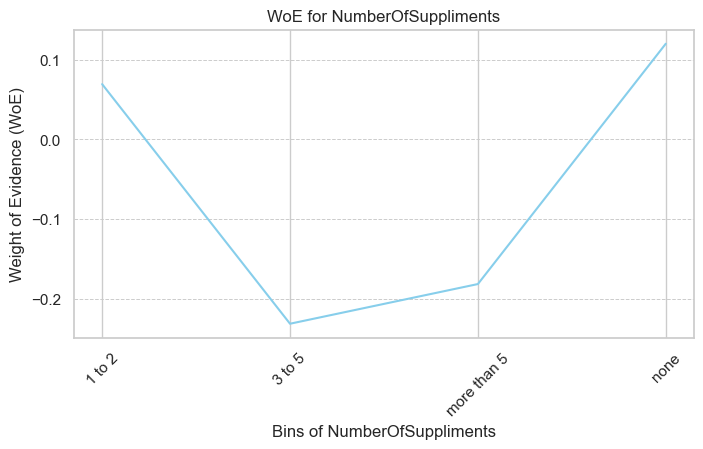

Categorical


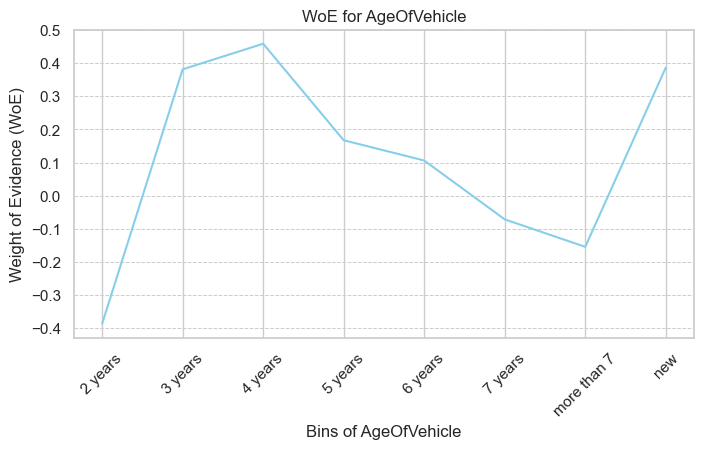

Categorical


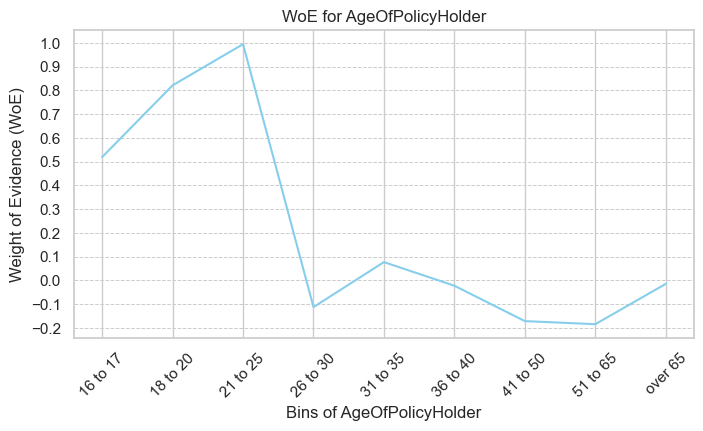

Categorical


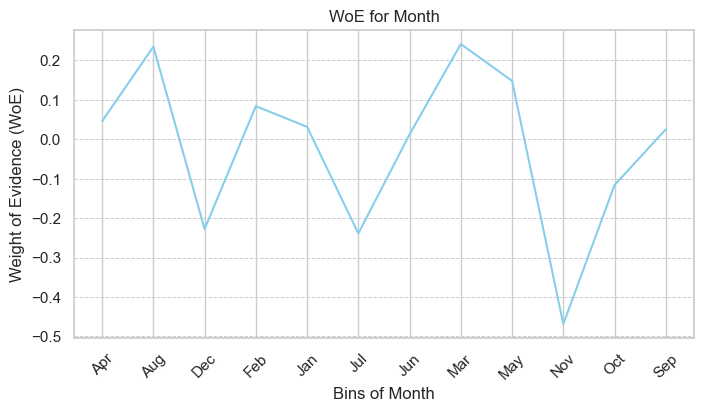

Categorical


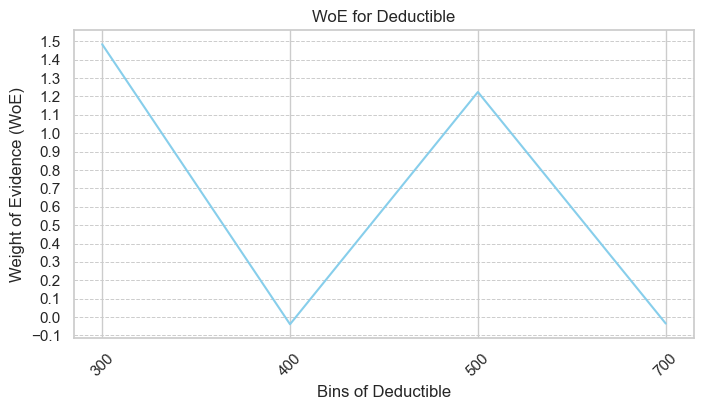

Categorical


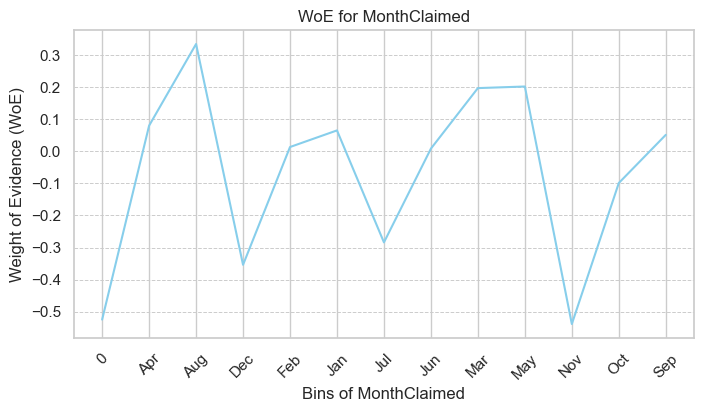

Categorical


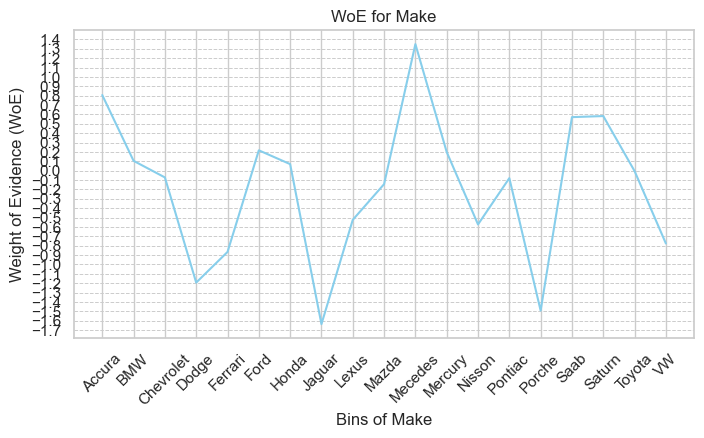

Categorical


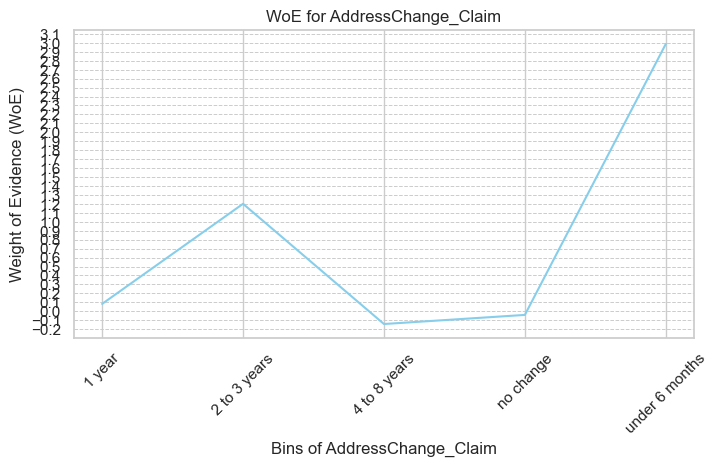

Categorical


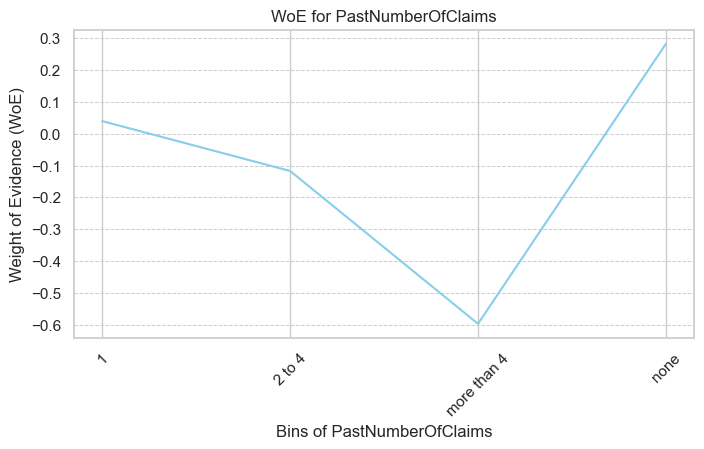

Categorical


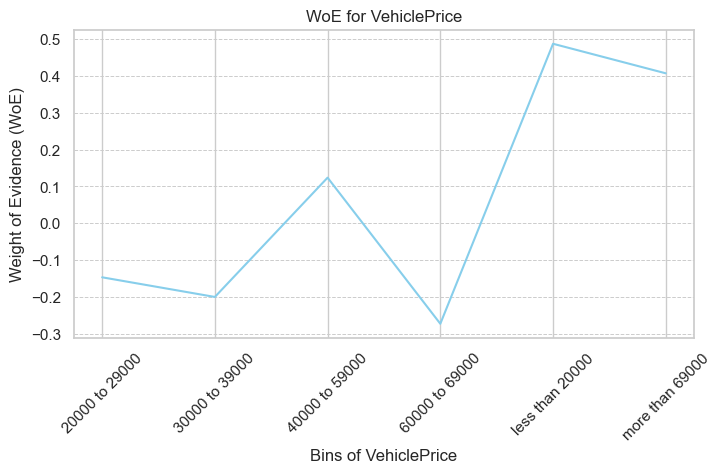

Categorical


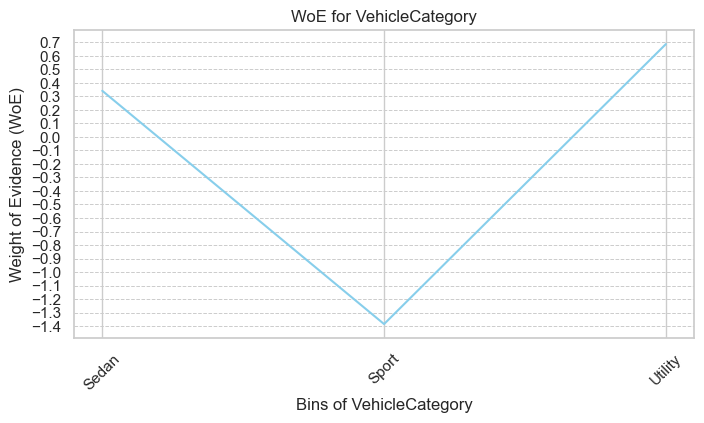

Categorical


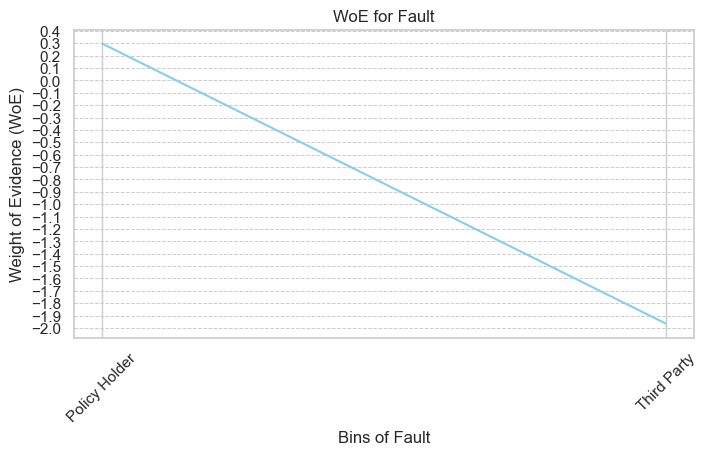

In [273]:
for feature in meaningful_features:
    if feature in numerical_features:
        print('Numerical')
        grouped, _ = calculate_woe_iv_numeric(df, feature, target)
    else:
        print('Categorical')
        grouped, _ = calculate_woe_iv_categorical(df, feature, target)
    plot_woe(grouped, feature)

### Further analysis to determine which bins to combine

In [274]:
df['NumberOfSuppliments'].value_counts()

NumberOfSuppliments
none           7047
more than 5    3867
1 to 2         2489
3 to 5         2017
Name: count, dtype: int64

In [275]:
df['NumberOfSuppliments'] = df['NumberOfSuppliments'].replace({
                                                'none': 'none or 1 to 2', 
                                                '1 to 2': 'none or 1 to 2', 
                                                '3 to 5': 'more than 3', 
                                                'more than 5': 'more than 3'
                                                })

In [276]:
df['AgeOfVehicle'].value_counts()

AgeOfVehicle
7 years        5807
more than 7    3981
6 years        3448
5 years        1357
new             373
4 years         229
3 years         152
2 years          73
Name: count, dtype: int64

In [277]:
df['AgeOfVehicle'] = df['AgeOfVehicle'].replace({
                                                '3 years': '3-4 years',
                                                '4 years': '3-4 years',
                                                '5 years': 'more than 5 years',
                                                '6 years': 'more than 5 years',
                                                '7 years': 'more than 5 years',
                                                'more than 7': 'more than 5 years'
                                                })

In [278]:
df['AgeOfPolicyHolder'].value_counts()

AgeOfPolicyHolder
31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
26 to 30     613
over 65      508
16 to 17     320
21 to 25     108
18 to 20      15
Name: count, dtype: int64

In [279]:
df['AgeOfPolicyHolder'] = df['AgeOfPolicyHolder'].replace({
                                                '41 to 50': '41 to 65',
                                                '51 to 65': '41 to 65',
                                                })

In [280]:
df['Month'] = df['Month'].replace({
                                    'Jan': 'Jan-Feb',
                                    'Feb': 'Jan-Feb'
                                    })

In [281]:
df['Deductible'] = df['Deductible'].astype(str)

In [282]:
df['MonthClaimed'] = df['MonthClaimed'].replace({
                                            'Jan': 'Jan-Feb',
                                            'Feb': 'Jan-Feb'
                                            })

In [283]:
df['Make'].value_counts()

Make
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: count, dtype: int64

In [284]:
df['Make'] = df['Make'].replace({
                                'Lexus': 'Lexus/Ferrari/Porche/Jaguar',
                                'Ferrari': 'Lexus/Ferrari/Porche/Jaguar',
                                'Porche': 'Lexus/Ferrari/Porche/Jaguar',
                                'Jaguar': 'Lexus/Ferrari/Porche/Jaguar'
                                })

In [285]:
df['VehiclePrice'] = df['VehiclePrice'].replace({
                                                '20000 to 29000': '20000 to 39000',
                                                '30000 to 39000': '20000 to 39000'
                                                })

In [286]:
meaningful_X = df[meaningful_features]
meaningful_X.head()

,NumberOfSuppliments,AgeOfVehicle,AgeOfPolicyHolder,Month,Deductible,MonthClaimed,Make,AddressChange_Claim,PastNumberOfClaims,VehiclePrice,VehicleCategory,Fault
0,none or 1 to 2,3-4 years,26 to 30,Dec,300,Jan-Feb,Honda,1 year,none,more than 69000,Sport,Policy Holder
1,none or 1 to 2,more than 5 years,31 to 35,Jan-Feb,400,Jan-Feb,Honda,no change,none,more than 69000,Sport,Policy Holder
2,none or 1 to 2,more than 5 years,41 to 65,Oct,400,Nov,Honda,no change,1,more than 69000,Sport,Policy Holder
3,more than 3,more than 5 years,41 to 65,Jun,400,Jul,Toyota,no change,1,20000 to 39000,Sport,Third Party
4,none or 1 to 2,more than 5 years,31 to 35,Jan-Feb,400,Jan-Feb,Honda,no change,none,more than 69000,Sport,Third Party


In [287]:
dummies_X = pd.get_dummies(meaningful_X, drop_first=True, dtype=int)
dummies_X.head()

,NumberOfSuppliments_none or 1 to 2,AgeOfVehicle_3-4 years,AgeOfVehicle_more than 5 years,AgeOfVehicle_new,AgeOfPolicyHolder_18 to 20,AgeOfPolicyHolder_21 to 25,AgeOfPolicyHolder_26 to 30,AgeOfPolicyHolder_31 to 35,AgeOfPolicyHolder_36 to 40,AgeOfPolicyHolder_41 to 65,AgeOfPolicyHolder_over 65,Month_Aug,Month_Dec,Month_Jan-Feb,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Deductible_400,Deductible_500,Deductible_700,MonthClaimed_Apr,MonthClaimed_Aug,MonthClaimed_Dec,MonthClaimed_Jan-Feb,MonthClaimed_Jul,MonthClaimed_Jun,MonthClaimed_Mar,MonthClaimed_May,MonthClaimed_Nov,MonthClaimed_Oct,MonthClaimed_Sep,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ford,Make_Honda,Make_Lexus/Ferrari/Porche/Jaguar,Make_Mazda,Make_Mecedes,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,AddressChange_Claim_2 to 3 years,AddressChange_Claim_4 to 8 years,AddressChange_Claim_no change,AddressChange_Claim_under 6 months,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,VehiclePrice_40000 to 59000,VehiclePrice_60000 to 69000,VehiclePrice_less than 20000,VehiclePrice_more than 69000,VehicleCategory_Sport,VehicleCategory_Utility,Fault_Third Party
0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0
2,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1


# Model creation

In [313]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

from catboost import CatBoostClassifier, Pool

from imblearn.ensemble import BalancedRandomForestClassifier


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Split dataset

In [288]:
X_train, X_test, y_train, y_test = train_test_split(dummies_X, y, test_size=0.2)

### Oversampling

In [290]:
os = RandomOverSampler()
X_train_o, y_train_o = os.fit_resample(X_train, y_train)

In [347]:
def cr_cm(y_true, y_pred):
    cr = classification_report(y_test, y_pred)
    print(cr)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

## LogisticRegression no hyperparam search using NOT oversampled data

              precision    recall  f1-score   support

           0       0.99      0.63      0.77      2913
           1       0.12      0.91      0.22       171

    accuracy                           0.64      3084
   macro avg       0.56      0.77      0.49      3084
weighted avg       0.94      0.64      0.74      3084

           0       0.99      0.63      0.77      2913

           1       0.12      0.91      0.22       171

    accuracy                           0.64      3084



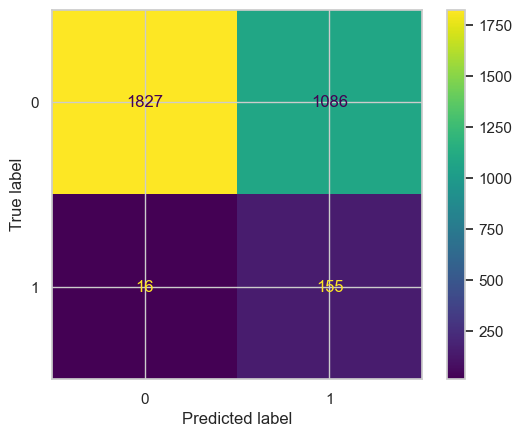

In [342]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_o, y_train_o)

y_pred = model.predict(X_test)

cr_cm(y_test, y_pred)

# XGBoost with hyperparam search using oversampled data

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.9897274854982433

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      2913
           1       0.13      0.43      0.20       171

    accuracy                           0.81      3084
   macro avg       0.55      0.63      0.55      3084
weighted avg       0.92      0.81      0.85      3084



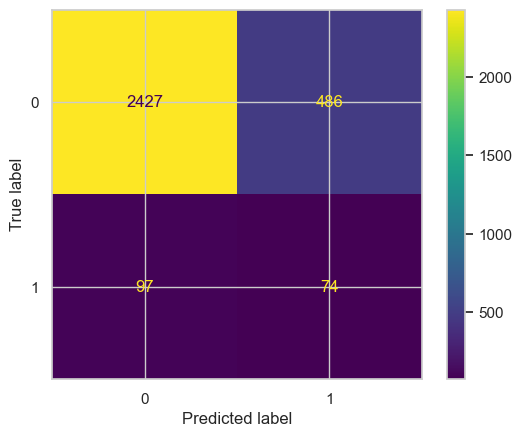

In [316]:
model = XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, verbose=0, n_jobs=-1, scoring='recall')

grid_search.fit(X_train_o, y_train_o)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

# LogisticRegression with hyperparam search using oversampled data

Best Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.7481005837214564

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      2913
           1       0.12      0.92      0.22       171

    accuracy                           0.64      3084
   macro avg       0.56      0.77      0.49      3084
weighted avg       0.94      0.64      0.73      3084



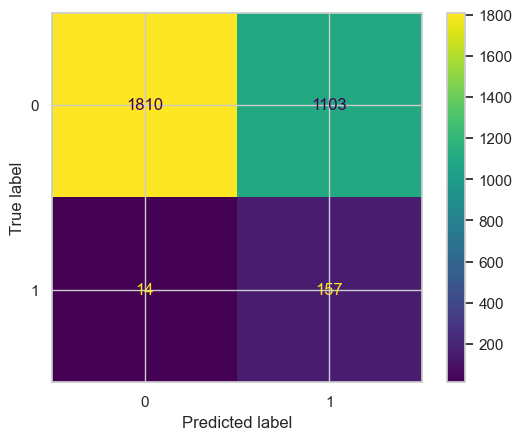

In [317]:
model = LogisticRegression(max_iter=1000)

param_grid = {
    'penalty': ['l1', 'l2'],           
    'C': [0.001, 0.01, 0.1, 1, 10],      
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, verbose=0, n_jobs=-1)

grid_search.fit(X_train_o, y_train_o)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)


# CatBoost no hyperparam search using oversampled data

Accuracy: 0.8664072632944229

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93      2913
           1       0.14      0.26      0.18       171

    accuracy                           0.87      3084
   macro avg       0.55      0.58      0.55      3084
weighted avg       0.91      0.87      0.89      3084



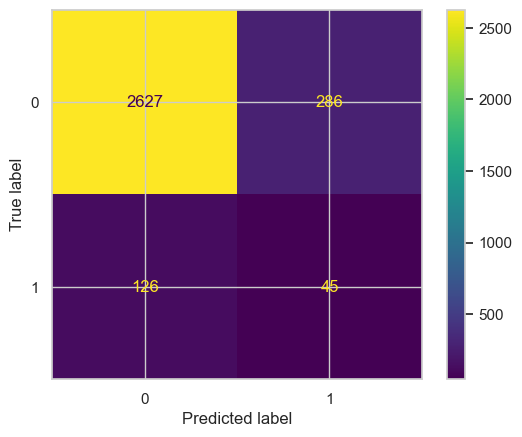

In [318]:
params = {
    'iterations': 1000, 
    'learning_rate': 0.1, 
    'depth': 16, 
    'loss_function': 'Logloss',
    'verbose': False 
}

train_pool = Pool(data=X_train_o, label=y_train_o)
test_pool = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=10, verbose_eval=False)

y_pred = model.predict(X_test)

cr_cm(y_test, y_pred)


# Ensemble: XGB + RFClassifier with hyperparam search using oversample data

Best parameters found:  {'rf__max_depth': 3, 'rf__n_estimators': 50, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}
Accuracy: 0.8073929961089494

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      2913
           1       0.15      0.52      0.23       171

    accuracy                           0.81      3084
   macro avg       0.56      0.67      0.56      3084
weighted avg       0.92      0.81      0.85      3084



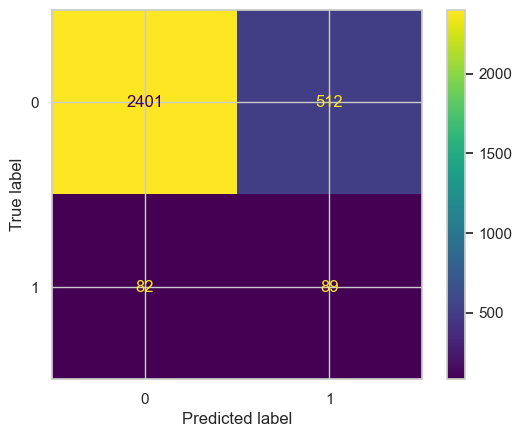

In [319]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1 
)

rf_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,  
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf)],
    voting='soft'
)

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_o, y_train_o)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

# Ensemble: XGB + RFClassifier with hyperparam search using NOT oversample data

# 

Best parameters found:  {'rf__max_depth': 7, 'rf__n_estimators': 50, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
Accuracy: 0.9468223086900129

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2913
           1       0.77      0.06      0.11       171

    accuracy                           0.95      3084
   macro avg       0.86      0.53      0.54      3084
weighted avg       0.94      0.95      0.92      3084



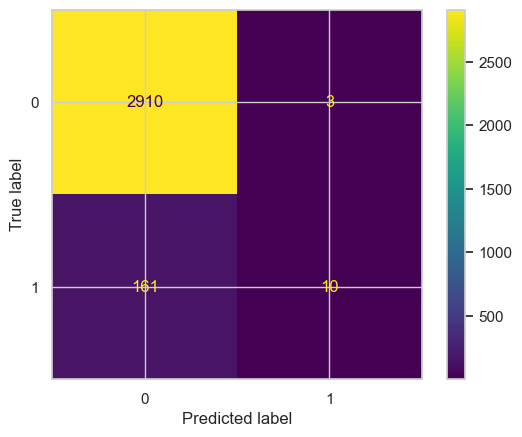

In [320]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,          
    max_depth=5,  
    learning_rate=0.1  
)

rf_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,   
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf)],
    voting='soft' 
)

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

# Ensemble: XGB + RFClassifier with hyperparam search using oversample data

Best parameters found:  {'rf__max_depth': 3, 'rf__n_estimators': 50, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}
Accuracy: 0.8073929961089494

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      2913
           1       0.15      0.52      0.23       171

    accuracy                           0.81      3084
   macro avg       0.56      0.67      0.56      3084
weighted avg       0.92      0.81      0.85      3084



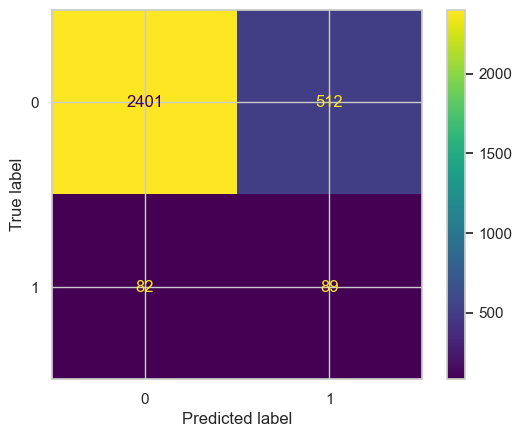

In [324]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,          
    max_depth=5,  
    learning_rate=0.1  
)

rf_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,   
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf)],
    voting='soft' 
)

param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_o, y_train_o)

print("Best parameters found: ", grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

# BalancedRFClassifier no hyperparam search using NOT oversampled data

Accuracy: 0.7376783398184177

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      2913
           1       0.13      0.67      0.22       171

    accuracy                           0.74      3084
   macro avg       0.55      0.71      0.53      3084
weighted avg       0.93      0.74      0.81      3084



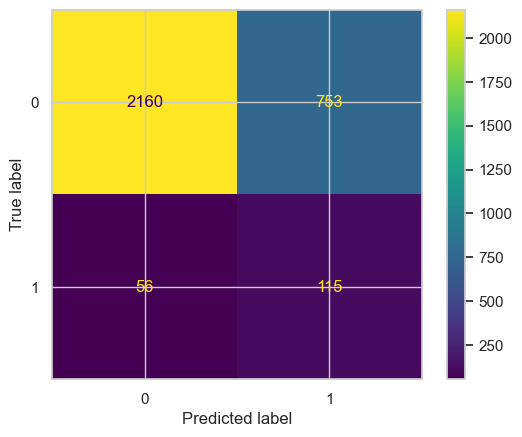

In [321]:
Bal_randForest = BalancedRandomForestClassifier(n_estimators=150, random_state=42, sampling_strategy='all', replacement=True, bootstrap=False)
balrandforest_model = Bal_randForest.fit(X_train,y_train)

y_pred_balforest = Bal_randForest.predict(X_test)

cr_cm(y_test, y_pred_balforest)

# BalancedRFClassifier with param search using NOT oversampled data

Best parameters found:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'sampling_strategy': 'auto'}
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      2913
           1       0.12      0.96      0.22       171

    accuracy                           0.61      3084
   macro avg       0.56      0.78      0.48      3084
weighted avg       0.95      0.61      0.71      3084



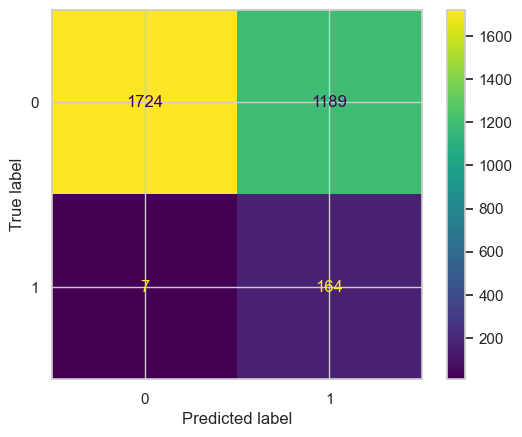

In [348]:
Bal_randForest = BalancedRandomForestClassifier(n_estimators=150, random_state=42, replacement=True, bootstrap=False)
balrandforest_model = Bal_randForest.fit(X_train, y_train)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'sampling_strategy': ['auto', 'not minority', 'not majority']
}

grid_search = GridSearchCV(estimator=Bal_randForest, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cr_cm(y_test, y_pred)

0.8151289942443934


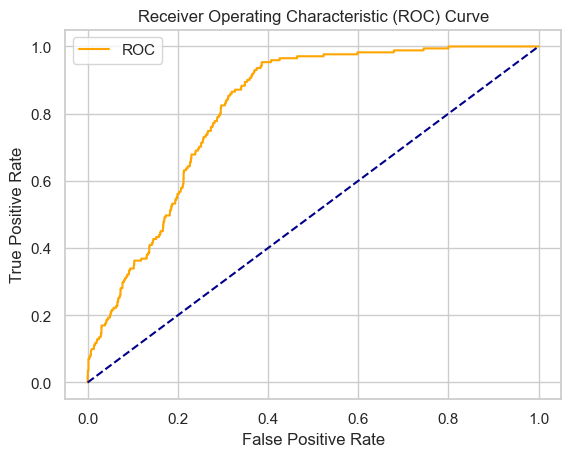

In [349]:
# roc_auc
y_pred_prob = best_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(roc_auc)
# roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

plt.show()